In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

On note $\alpha = (\alpha_1, \alpha_2, \alpha_3, \alpha_4) \in \mathbb{R}^4 $

Le problème des moindres carrés correspondant à l'identification de $\alpha$ dans (2) est : 

$ \alpha = argmin_{x \in \mathbb{R}^4}||Dx^T-(v_{réelle}(i+1)-v_{réelle}(i))||^2 $ où, $ \forall i \in [0, N], D_{i, \cdot} = \Delta t(1, -v_i, I(i), T(i))$ et $v_{réelle,i} = v(i) $

0.009996924023377422
[-0.29420791  0.02131773  0.02853839  0.01429096]


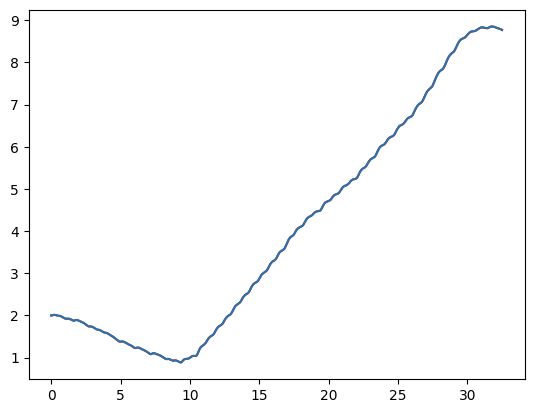

In [22]:
df = pd.read_csv("data_velo.csv")

vitesse = df["Vitesse [m/s]"].tolist()
intensite = df["I [A]"].tolist()
couple = df["Couple pédale [Nm]"].tolist()
temps = df["Time [s]"].tolist()

N = len(temps)
deltat = max(temps)/N
print(deltat)

D = np.array([[deltat, -deltat*vitesse[i], deltat*intensite[i], deltat*couple[i]] for i in range(N)])
#print(D)

vitesse_decalee = vitesse[1:] + [vitesse[-1]]

alpha = np.linalg.lstsq(D, np.array(vitesse_decalee) - np.array(vitesse), rcond=None)[0]

print(alpha)


vitesse_simulee = [vitesse[0]]
for i in range(N-2): 
    vitesse_simulee.append(vitesse_simulee[i] + deltat*(alpha[0] - alpha[1]*vitesse_simulee[i] + alpha[2]*intensite[i] + alpha[3]*couple[i]))

plt.plot(temps, vitesse, 'r')
plt.plot(temps[:N-1], vitesse_simulee)

7.a) 
On considère la matrice $A = A^T_kA_k$ définie positive (par hypothèse), et on définit $ U=a_{k+1} \in M _{m,1}(\mathbb{R})$.
On a donc aussi $\tilde{A} = A^T_{k+1}A_{k+1}$ qui est inversible. Ainsi, d'après la formule de SHerman-Morrison-Woodburry :
$$ \tilde{A}^{-1} = A^{-1} - A^{-1}U(I_p + U^TA^{-1}U)^{-1}U^TA^{-1}$$
Donc comme $p=1$ et $U=a_{k+1}$ :  
$$ \tilde{A}^{-1} = A^{-1} - A^{-1}a_{k+1}\frac{1}{1 + a_{k+1}^TA^{-1}a_{k+1}}a_{k+1}^TA^{-1}$$

Avec  $A = A^T_kA_k$ et en introduisant $\gamma_k = \frac{1}{1 + a_{k+1}^TA^{-1}a_{k+1}}$ :  
$$ \tilde{A}^{-1} = (A^T_kA_k)^{-1} - \gamma_k(A^T_kA_k)^{-1}a_{k+1} a_{k+1}^T(A^T_kA_k)^{-1}$$

Avec $K_k = \gamma_k(A^T_kA_k)^{-1}a_{k+1}$ on obtient : 

$$ \tilde{A}^{-1} = (A^T_kA_k)^{-1} - K_k a_{k+1}^T(A^T_kA_k)^{-1}$$

7. b)
Par définition, on a:
$$x_{k+1} = (A^T_{k+1}A_{k+1})^{-1}A^T_{k+1}b_{k+1} =  \tilde{A}^{-1}A^T_{k+1}b_{k+1}$$
D'où, avec la 7.a) :

$$
\begin{align*}
    x_{k+1} & = [(A^T_kA_k)^{-1} - K_k a_{k+1}^T(A^T_kA_k)^{-1}]A^T_{k+1}b_{k+1} \\
            & = \quad(A^T_kA_k)^{-1}A^T_{k+1}b_{k+1}- K_k a_{k+1}^T(A^T_kA_k)^{-1}A^T_{k+1}b_{k+1}
\end{align*}
$$

Or : $A^T_{k+1}b_{k+1} = (A^T_k, a_{k+1})(b_k, \tilde{b}) = A^T_kb_k + \tilde{b}a_{k+1}$

Donc : 

$$
\begin{align*}
    x_{k+1} &= (A^T_kA_k)^{-1}(A^T_kb_k + \tilde{b}a_{k+1})- K_k a_{k+1}^T(A^T_kA_k)^{-1}(A^T_kb_k + \tilde{b}a_{k+1}) \\
            & = \quad x_k + \tilde{b}(A^T_kA_k)^{-1} a_{k+1}- K_k a_{k+1}^Tx_k - \tilde{b}K_k a_{k+1}^T(A^T_kA_k)^{-1}a_{k+1} \\
            & = \quad x_k + \frac{\tilde{b}}{\gamma_k}K_k- K_k a_{k+1}^Tx_k - \tilde{b}K_k a_{k+1}^T(A^T_kA_k)^{-1}a_{k+1} \\
            & = \quad x_k + K_k(\frac{\tilde{b}}{\gamma_k}- a_{k+1}^Tx_k - \tilde{b}a_{k+1}^T(A^T_kA_k)^{-1}a_{k+1}) \\
            & = \quad x_k + K_k(\frac{\tilde{b}}{\gamma_k}- a_{k+1}^Tx_k - \tilde{b}(\frac{1}{\gamma_k}-1)) \\
            & = \quad x_k + K_k(\tilde{b}- a_{k+1}^Tx_k)
\end{align*}
$$

7. c)
On peut definir un algorithme ne nécessitant pas d'inversion de matrices au cours des itérations car en exprimant $x_{k+1}$ en fonction de $x_k$, l'inversion apparaît dans $K_k$. Or il est question d'inverser $(A^T_kA_k)$, chose que nous pouvons faire sans le calculer explicitement étant donnée la relation de récurrence (7).

In [5]:
a = np.array([[deltat, -deltat*vitesse[i], deltat*intensite[i], deltat*couple[i]] for i in range(N)])
b = np.array([[vitesse_decalee[i]-vitesse[i]] for i in range(N-1)])


def SMW(n):
    if n == 0 :
        return np.linalg.inv(np.dot(a[0][:, np.newaxis], a[0][np.newaxis, :]))

    else : 
        gamma = 1/(1 + np.dot(a[n], np.dot(SMW(n-1), a[n])))
        K = gamma * np.dot(SMW(n-1), a[n])
        return SMW(n-1) - np.dot(np.outer(K, a[n]), SMW(n-1))



def moindres_carres_recursifs(n):
    if n == 0 :
        x_0 = np.dot(SMW(0), np.transpose(a[0]))*b[0]
        return x_0
    else : 
        gamma = 1/(1 + np.dot(a[n], np.dot(SMW(n-1), a[n])))
        K = gamma * np.dot(SMW(n-1), a[n])
        return moindres_carres_recursifs(n-1) + K(b[n] - np.dot(a[n],moindres_carres_recursifs(n-1)))

print(np.linalg.inv(np.dot(a[0][:, np.newaxis], a[0][np.newaxis, :])))


LinAlgError: Singular matrix

In [30]:
a = np.array([[deltat, -deltat*vitesse[i], deltat*intensite[i], deltat*couple[i]] for i in range(N)])
b = np.array([[vitesse_decalee[i]-vitesse[i]] for i in range(N-1)])


def SMW(n):
    if n == 4 :
        A = np.vstack((a[0], a[1], a[2], a[3], a[4]))
        return np.linalg.inv(np.dot(np.transpose(A), A))
    
    elif n > 4 : 
        gamma = 1/(1 + np.dot(a[n], np.dot(SMW(n-1), a[n])))
        K = gamma * np.dot(SMW(n-1), a[n])
        return SMW(n-1) - np.dot(np.outer(K, a[n]), SMW(n-1))
    else :
        return 'n doit être supérieur à 4'



def moindres_carres_recursifs(n):
    if n == 4 :
        return np.array([0, 0, 0, 0])
    
    elif n > 4 : 
        gamma = 1/(1 + np.dot(a[n], np.dot(SMW(n-1), a[n])))
        K = gamma * np.dot(SMW(n-1), a[n])
        return moindres_carres_recursifs(n-1) + K*(b[n] - np.dot(a[n],moindres_carres_recursifs(n-1)))
    
    else : 
        'n doit être supérieur à 4'


moindres_carres_recursifs(10)

array([-4.81234439e+01, -2.40126004e+01,  2.45531159e-03,  6.57332565e-03])

In [32]:
a = np.array([[deltat, -deltat*vitesse[i], deltat*intensite[i], deltat*couple[i]] for i in range(N)])
b = np.array([[vitesse_decalee[i]-vitesse[i]] for i in range(N-1)])


def SMW(n):
    if n == 4 :
        A = np.vstack((a[0], a[1], a[2], a[3], a[4]))
        return np.linalg.inv(np.dot(np.transpose(A), A))
    
    elif n > 4 : 
        gamma = 1/(1 + np.dot(a[n], np.dot(SMW(n-1), a[n])))
        K = gamma * np.dot(SMW(n-1), a[n])
        return SMW(n-1) - np.dot(np.outer(K, a[n]), SMW(n-1))
    else :
        return 'n doit être supérieur à 4'



def moindres_carres_recursifs_complet(n):
    if n == 4 :
        A = np.vstack((a[0], a[1], a[2], a[3], a[4]))
        return (np.linalg.inv(np.dot(np.transpose(A), A)), np.array([0, 0, 0, 0]))
    
    elif n > 4 : 
        gamma = 1/(1 + np.dot(a[n], np.dot(moindres_carres_recursifs_complet(n-1)[0], a[n])))
        K = gamma * np.dot(moindres_carres_recursifs_complet(n-1)[0], a[n])
        return (moindres_carres_recursifs_complet(n-1)[0] - np.dot(np.outer(K, a[n]), moindres_carres_recursifs_complet(n-1)[0]), moindres_carres_recursifs_complet(n-1)[1] + K*(b[n] - np.dot(a[n], moindres_carres_recursifs_complet(n-1)[1])))
    
    else : 
        'n doit être supérieur à 4'


moindres_carres_recursifs_complet(11)[1]

array([-1.50481626e+01, -7.39375651e+00,  1.36763914e-02,  1.42203969e-02])

# 3e partie


9. Il y a en toute généralité un autre terme à prendre en compte lié à la pente de la route lorsqu'on n'est plus en terrain plat. En l'occurence ce terme est une fonction de la position $\gamma$ qui n'est pas linéaire

Si la pente est nulle, la fonction f ne dépend plus que de 

On définit $\mathbf{z}$ : 

$$
\mathbf{z} = \begin{pmatrix}
T_0 \\
T_1 \\
\vdots \\
T_N \\
x_0 \\
x_1 \\
\vdots \\
x_N \\
v_0 \\
v_1 \\
\vdots \\
v_n \\
I_0 \\
I_1 \\
\vdots \\
I_N

\end{pmatrix} \in \mathbb{R}^{4N+4}
$$

$$
\mathbf{c_{éq, 1}}(z) = \begin{pmatrix}
x_1 - x_0 - \Delta t v_0 \\
x_2 - x_1 - \Delta t v_1 \\
\vdots \\
x_N - x_{N-1} - \Delta t v_{N-1}
\end{pmatrix} \in \mathbb{R}^N
$$

$$
\mathbf{c_{éq, 2}}(z) = \begin{pmatrix}
v_1 - v_0 + \Delta t (\alpha_1 - \alpha_2 v_0 + \alpha_3 I_0 + \alpha_4 T_0 - g\gamma(x_0)) \\
v_2 - v_1 + \Delta t (\alpha_1 - \alpha_2 v_1 + \alpha_3 I_1 + \alpha_4 T_1 - g\gamma(x_1)) \\
\vdots \\
v_N - v_{N-1} + \Delta t (\alpha_1 - \alpha_2 v_{N-1} + \alpha_3 I_{N-1} + \alpha_4 T_{N-1} - g\gamma(x_{N-1})) 
\end{pmatrix} \in \mathbb{R}^N
$$

$$
\mathbf{c_{in, 3}}(z) = \begin{pmatrix}
I_0 - I_M \\
I_1 - I_M \\
\vdots \\
I_N - I_M
\end{pmatrix} \in \mathbb{R}^{N+1}
$$

$$
\mathbf{c_{in, 4}}(z) = \begin{pmatrix}
-I_0 \\
-I_1 \\
\vdots \\
-I_N
\end{pmatrix} \in \mathbb{R}^{N+1} 
$$

$$
\mathbf{c_{in, 5}}(z) = \sum_{i = 0}^{N} \Delta t I_i - Q_{bat} \in \mathbb{R}
$$


In [41]:
#Fonction à minimiser

def f(z):
    z = np.array(z)
    return (np.sum(z[0 : N+1]**2))


# Définition des contraintes

def c1(z):
    z = np.array(z)
    return z[N+2 : 2*N+2] - z[N+1 : 2*N+1] - deltat * z[2*N+2 : 3*N+2]

def c2(z):
    z = np.array(z)
    return z[2*N+3 : 3*N+3] - z[2*N+2 : 3*N+2] + deltat * ( alpha_1 - alpha_2 * z[2*N+2 : 3*N+2] + alpha_3 * z[3*N+3 : 4*N+3] + alpha_4 * z[0 : N] )

def c3(z):
    z = np.array(z)
    return z[3*N+3 : 4*N+4] - I_M

def c4(z): 
    z = np.array(z)
    return - z[3*N+3 : 4*N+4]

def c5(z): 
    z = np.array(z)
    return deltat * np.sum(z[3*N+3 : 4*N+4]) - Q_bat

contraintes = ({'type' : 'eq', 'fun' : c1}, {'type' : 'eq', 'fun' : c2}, {'type' : 'ineq', 'fun' : c3}, {'type' : 'ineq', 'fun' : c4}, {'type' : 'ineq', 'fun' : c5})






41 41


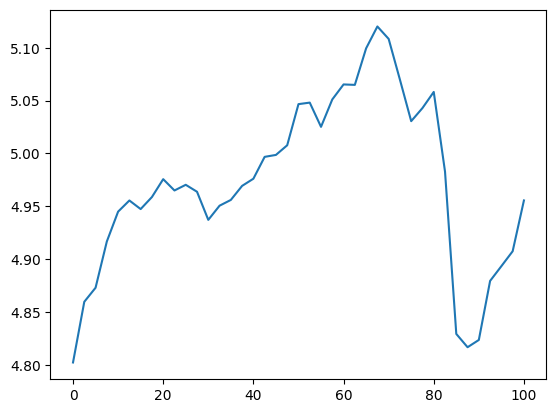

In [52]:
T = 100
deltat = 2.5
N = int(T/deltat)
Q_bat = 700
I_M = 30
alpha_1, alpha_2, alpha_3, alpha_4 = alpha

#Choix des variables initiales : 

couple_init = [0 for i in range (N+1)]
position_init = [12.5*i for i in range(N+1)] #vitesse uniforme
vitesse_init = [5 for i in range(N+1)] #vitesse uniforme
intensite_init = [0.3 for i in  range(N+1)] #on se rapproche de la contraitne Q_bat

z_init = np.array(couple_init + position_init + vitesse_init + intensite_init)

#Minimisation sous contraintes

sol = minimize(f, z_init, constraints = contraintes)

temps = [2.5*i for i in range(N+1)]
couple_sol = sol.x[0:N+1]
position_sol = sol.x[N+1:2*N+2]
vitesse_sol = sol.x[2*N+2:3*N+3]
intensite_sol = sol.x[3*N+3:4*N+4]

plt.plot(temps, vitesse_sol)
plt.show()
